# Fine Tuned Mask-RCNN on Waste Image Dataset

---



Fine tunes the head of the Mask-RCNN Algorithm on custom image set, stores the weights for the network in the log directory, and then use the weight file to run the detection and calculates metrics on testing and real data.

### Install and Import Dependencies

---



In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Mask_RCNN')

In [ ]:
!pip3 install -r requirements.txt

In [ ]:
!pip uninstall keras-nightly
!pip uninstall -y tensorflow
!pip install h5py==2.10.0
!pip install tensorflow==1.15
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.1.6
!pip install scikit-image==0.16.2

In [ ]:
!python3 setup.py install

In [ ]:
ROOT_DIR = os.path.abspath(".")
ROOT_DIR

'/content/drive/My Drive/Colab Notebooks/Mask_RCNN'

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


### Configuration and Preprocessing

---



In [ ]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "food_waste"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 9  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    # IMAGE_MIN_DIM = 128
    # IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    DETECTION_MIN_CONFIDENCE = 0.9
    
config = ShapesConfig()
config.display()

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
import json 
from PIL import Image, ImageDraw
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, annotation_dir, images_dir):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        coco_json = json.load(open(annotation_dir))
        
        # Add the class names using the base method from utils.Dataset
        source_name = "food_waste"
        for category in coco_json['categories']:
            class_id = category['id']

            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(
                    class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}

        # Split the dataset, if train, get 90%, else 10%
        len_images = len(coco_json['images'])
        
        for i in range(0, int(len_images)):
            image = coco_json['images'][i]
            image_id = image['id']
            if image_id in seen_images:
                print("Duplicate image name (Not Added): {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Image with issing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the images
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "food_waste":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids


In [ ]:
IMAGES_DIR = "/content/drive/MyDrive/CS4641 Project/Test_Set"
ANNOTATIONS_DIR = "/content/drive/MyDrive/CS4641 Project/labels_Test_23Images_2021-12-02-05-49-55.json"

# Training dataset to fine tune the Mask-RCNN Head
TRAINING_IMG_DIR = "/content/drive/MyDrive/CS4641 Project/All_Images"
TRAINING_ANNOTATION_DIR = "/content/drive/MyDrive/CS4641 Project/labels_116Images_2021-12-01-06-45-38.json"
dataset_train = ShapesDataset()
dataset_train.load_shapes(TRAINING_ANNOTATION_DIR, TRAINING_IMG_DIR)
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(ANNOTATIONS_DIR, IMAGES_DIR)
dataset_val.prepare()

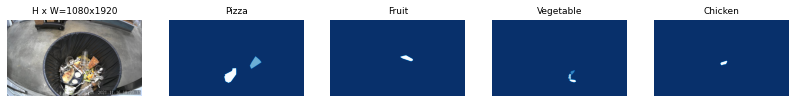

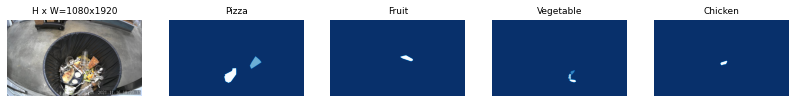

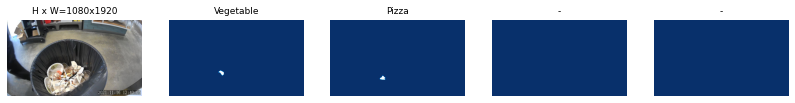

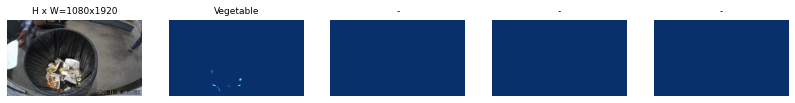

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 4)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

In [ ]:
MODEL_DIR

'/content/drive/My Drive/Colab Notebooks/Mask_RCNN/logs'

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)







Re-starting from epoch 5


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')


Starting at epoch 5. LR=0.001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/Mask_RCNN/logs/food_waste20211203T0226/mask_rcnn_food_waste_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 6/20
 99/100 [============================>.] - ETA: 2s - loss: 0.7233 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2336 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.1039 - mrcnn_mask_loss: 0.2797

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 330s 3s/step - loss: 0.7230 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2335 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.1037 - mrcnn_mask_loss: 0.2797 - val_loss: 2.7088 - val_rpn_class_loss: 0.0193 - val_rpn_bbox_loss: 1.0437 - val_mrcnn_class_loss: 0.6045 - val_mrcnn_bbox_loss: 0.6447 - val_mrcnn_mask_loss: 0.3967

Epoch 7/20
100/100 [==============================] - 238s 2s/step - loss: 0.6324 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1822 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.2590 - val_loss: 2.3753 - val_rpn_class_loss: 0.0159 - val_rpn_bbox_loss: 0.8267 - val_mrcnn_class_loss: 0.5865 - val_mrcnn_bbox_loss: 0.5595 - val_mrcnn_mask_loss: 0.3866
Epoch 8/20
100/100 [==============================] - 238s 2s/step - loss: 0.5571 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1410 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.2432 - val_loss: 3.0162 - val_rpn_class_loss: 0.020

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    DETECTION_MIN_CONFIDENCE = 0.75


inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/Colab Notebooks/Mask_RCNN/logs/food_waste20211203T0226/mask_rcnn_food_waste_0020.h5
Re-starting from epoch 20


[[4 1]
 [6 4]]


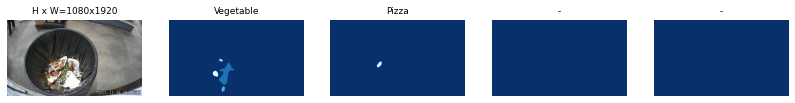

[[3 5]
 [4 2]]


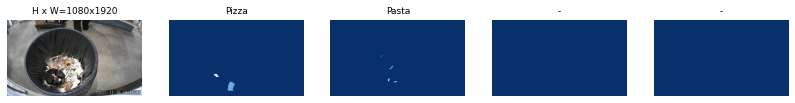

[[5 1]
 [6 5]]


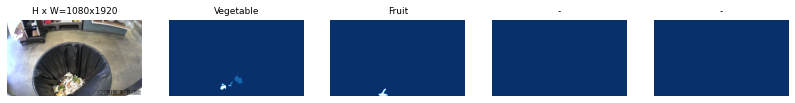

[[5 1]
 [6 4]
 [8 1]
 [9 1]]


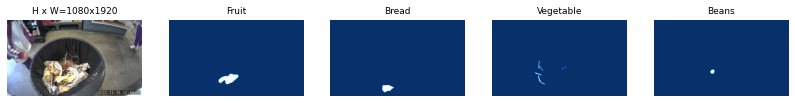

In [ ]:
# Load and display random samples
import numpy 
image_ids = np.random.choice(dataset_val.image_ids, 4)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)

    print(numpy.asarray((numpy.unique(class_ids, return_counts=True))).T)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (22,)                 min:    0.00000  max: 1920.00000  float64
gt_class_id              shape: (5,)                  min:    1.00000  max:    5.00000  int32
gt_bbox                  shape: (5, 4)                min:  432.00000  max:  763.00000  int32
gt_mask                  shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool


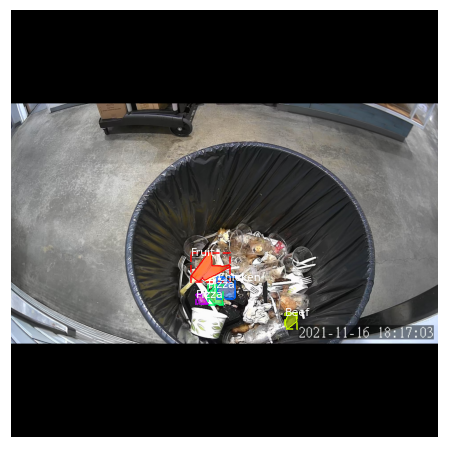

In [ ]:
# Test on a random image

image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


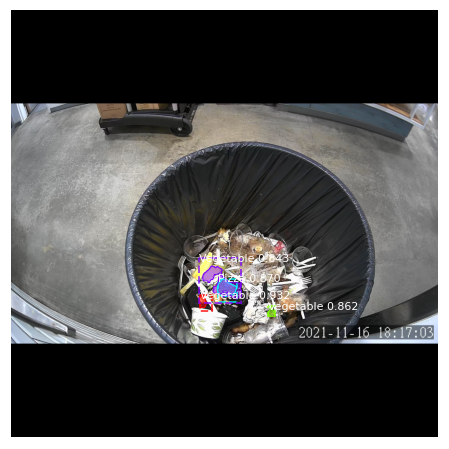

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in range(0, len(dataset_val.image_ids)):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

print("precisions: ", precisions)
print("mAP: ", np.mean(APs))

precisions:  [0.5        0.5        0.5        0.33333333 0.        ]
mAP:  0.12070048455742821


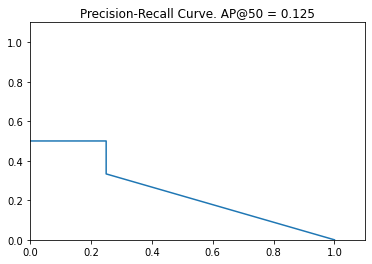

In [ ]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

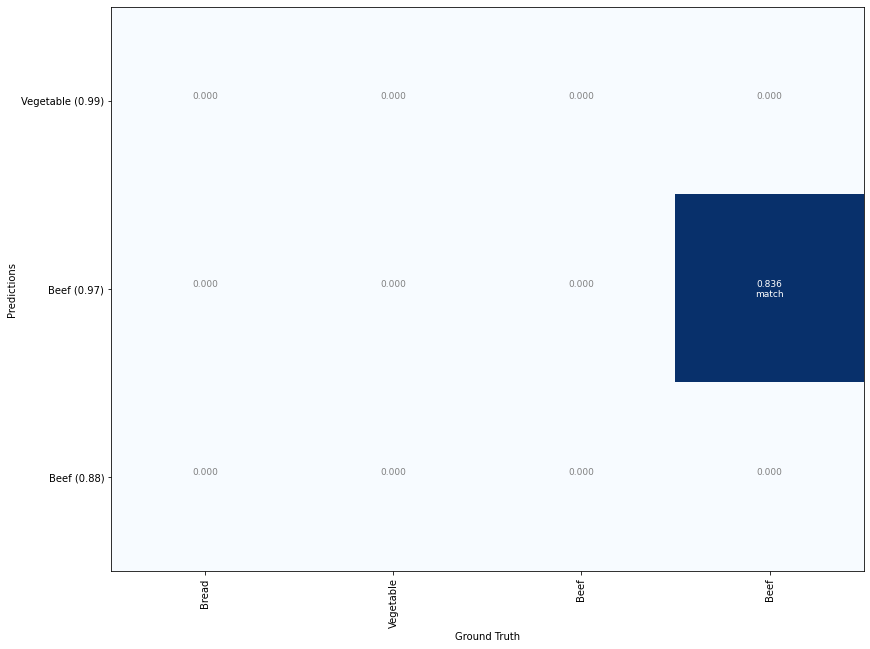

In [ ]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_train.class_names)